In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import os
from scipy import stats
from edfreader import read_edf

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    #print(a)

exp = []
for x in range(len(liste)) :
    if liste[x][0]=='enregistrement' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [4]:
timeStr = {}
timeStr['AM'] = '2017-10-23_100057'
timeStr['BMC'] = '2017-09-26_095637'
timeStr['CS'] = '2017-10-03_134421'
timeStr['DC']= '2017-09-27_161040'
timeStr['FM'] = '2017-10-03_143803'
timeStr['IP'] = '2017-09-28_115250'
timeStr['LB'] = '2017-09-20_151043'
timeStr['OP'] = '2017-10-26_121823'
timeStr['RS'] = '2017-11-08_094717'
timeStr['SR'] = '2017-11-16_153313'
timeStr['TN'] = '2017-11-08_150410'
timeStr['YK'] = '2017-11-17_172706'

In [5]:
gradient_deg_NAN = []
StimOf = []
tracker_0 = []

for x in range(len(exp)) :
    gradient_deg_NAN.append([])
    StimOf.append([])
    tracker_0.append([])
        
    N_blocks = exp[x]['N_blocks']
    N_trials = exp[x]['N_trials']
    sujet = exp[x]['observer'] # sujet

    resultats = os.path.join('..','data', 'enregistrement_' + sujet + '_' + timeStr[sujet] + '.asc')
    data = read_edf(resultats, 'TRIALID')
    
    for block in range(N_blocks) :
        gradient_deg_NAN[x].append([])
        StimOf[x].append([])
        tracker_0[x].append([])
        
        for trial in range(N_trials) :
            gradient_deg_NAN[x][block].append([])
            StimOf[x][block].append([])
            tracker_0[x][block].append([])
            
            trial_data = trial + N_trials*block
            
            data_x = data[trial_data]['x']
            trackertime = data[trial_data]['trackertime']
            StimulusOf = data[trial_data]['events']['msg'][14][0]
            
            saccades = data[trial_data]['events']['Esac']
            trackertime_0 = data[trial_data]['trackertime'][0]

            gradient_x = np.gradient(data_x) # gradient en px/ms
            gradient_deg = gradient_x * 1/exp[x]['px_per_deg'] * 1000 # gradient en deg/sec

            ##################################################
            StimOf[x][block][trial] = StimulusOf
            tracker_0[x][block][trial] = trackertime_0
            ##################################################
            
            ##################################################
            # SUPPRESSION DES SACCADES
            ##################################################
            gradient_deg_NAN[x][block][trial] = gradient_deg

            for s in range(len(saccades)) :
                if saccades[s][1]-trackertime_0+15 <= (len(trackertime)) :
                    for x_data in np.arange((saccades[s][0]-trackertime_0-5), (saccades[s][1]-trackertime_0+15)) :
                        gradient_deg_NAN[x][block][trial][x_data] = np.nan
                else :
                    for x_data in np.arange((saccades[s][0]-trackertime_0-5), (len(trackertime))) :
                        gradient_deg_NAN[x][block][trial][x_data] = np.nan


# P_reel

In [6]:
def Trace_Moyenne_P_reel(delta, color, PROBA, ax=None) :
    va_r = {}
    va_l = {}
    mean_va_r = {}
    mean_va_l = {}

    for p_r in PROBA :
        va_r[p_r] = []
        va_l[p_r] = []
        mean_va_r[p_r] = []
        mean_va_l[p_r] = []

    for x in range(len(exp)) :

        N_blocks = exp[x]['N_blocks']
        N_trials = exp[x]['N_trials']
        p = exp[x]['p']


        for block in range(N_blocks) :
            for trial in range(N_trials) :                
                StimulusOf = StimOf[x][block][trial]
                trackertime_0 = tracker_0[x][block][trial]


                bino=p[trial, block, 0]
                p_reel = p[trial, block, 1]

                for p_r in PROBA :
                    if p_reel >= p_r and p_reel < (p_r + delta) :
                        if bino == 0 : # droite c'est 1 gauche c'est 0
                            va_l[p_r].append(gradient_deg_NAN[x][block][trial][StimulusOf-trackertime_0:StimulusOf-trackertime_0+1300])
                        elif bino == 1 :
                            va_r[p_r].append(gradient_deg_NAN[x][block][trial][StimulusOf-trackertime_0:StimulusOf-trackertime_0+1300])


    if ax is None :
        fig_width = 20
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, 1*fig_width/(1.6180*1)))
    ax.plot(np.zeros(1000), c='k')            
    x=0                      
    for p_r in PROBA :
        for tps in range(1000) :
            liste_r = []
            for a in range(len(va_r[p_r])) :
                liste_r.append(va_r[p_r][a][tps])
            mean_va_r[p_r].append(np.nanmean(liste_r))

            liste_l = []
            for b in range(len(va_l[p_r])) :
                liste_l.append(va_l[p_r][b][tps])
            mean_va_l[p_r].append(np.nanmean(liste_l))

        ax.plot(mean_va_r[p_r], c=color[x], label=' p = %s - %s'%(p_r, p_r+delta), alpha=0.7)
        ax.plot(mean_va_l[p_r], c=color[x], alpha=0.7)
        x=x+1 

    ax.axvspan(0, 300, color='r', alpha=0.2)
    ax.axvspan(300, 1000, color='k', alpha=0.15)
    ax.legend()
    return ax

# P_hat

In [7]:
import bayesianchangepoint as bcp

In [8]:
p_hat_bcp_e = []
p_hat_bcp_m = []

for x in range(len(exp)):
    
    p_hat_bcp_e.append([])
    p_hat_bcp_m.append([])
    
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    tau = N_trials/5.
    h = 1./tau
    
    #print('\n', exp[x]['observer'])
    for block in range(N_blocks):
        p_hat_bcp_e[x].append([])
        p_hat_bcp_m[x].append([])
        
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            #----------------------------------------------------
            p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=h, p0=.5)
            p_hat_e, r_hat_e = bcp.readout(p_bar, r, beliefs, mode='expectation')
            p_hat_m, r_hat_m = bcp.readout(p_bar, r, beliefs, mode='max')
            
            p_hat_bcp_e[x][block].extend(p_hat_e)
            p_hat_bcp_m[x][block].extend(p_hat_m)

In [9]:
def Trace_Moyenne_P_hat(delta, color, PROBA, ax=None) :
    va_r = {}
    va_l = {}
    mean_va_r = {}
    mean_va_l = {}

    for p_r in PROBA :
        va_r[p_r] = []
        va_l[p_r] = []
        mean_va_r[p_r] = []
        mean_va_l[p_r] = []

    for x in range(len(exp)) :

        N_blocks = exp[x]['N_blocks']
        N_trials = exp[x]['N_trials']
        p = exp[x]['p']


        for block in range(N_blocks) :
            for trial in range(N_trials) :                
                StimulusOf = StimOf[x][block][trial]
                trackertime_0 = tracker_0[x][block][trial]


                bino=p[trial, block, 0]
                phat = p_hat_bcp_e[x][block][trial]
                #phat = p_hat_bcp_m[x][block][trial]
                
                for p_r in PROBA :
                    if phat >= p_r and phat < (p_r + delta) :
                        if bino == 0 : # droite c'est 1 gauche c'est 0
                            va_l[p_r].append(gradient_deg_NAN[x][block][trial][StimulusOf-trackertime_0:StimulusOf-trackertime_0+1300])
                        elif bino == 1 :
                            va_r[p_r].append(gradient_deg_NAN[x][block][trial][StimulusOf-trackertime_0:StimulusOf-trackertime_0+1300])

    if ax is None :
        fig_width = 20
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, 1*fig_width/(1.6180*1)))
    ax.plot(np.zeros(1000), c='k')            
    x=0                      
    for p_r in PROBA :
        for tps in range(1000) :
            liste_r = []
            for a in range(len(va_r[p_r])) :
                liste_r.append(va_r[p_r][a][tps])
            mean_va_r[p_r].append(np.nanmean(liste_r))

            liste_l = []
            for b in range(len(va_l[p_r])) :
                liste_l.append(va_l[p_r][b][tps])
            mean_va_l[p_r].append(np.nanmean(liste_l))

        ax.plot(mean_va_r[p_r], c=color[x], label=' p = %s - %s'%(p_r, p_r+delta), alpha=0.7)
        ax.plot(mean_va_l[p_r], c=color[x], alpha=0.7)
        x=x+1 

    ax.axvspan(0, 300, color='r', alpha=0.2)
    ax.axvspan(300, 1000, color='k', alpha=0.15)
    ax.legend()
    return ax

# Figure

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice


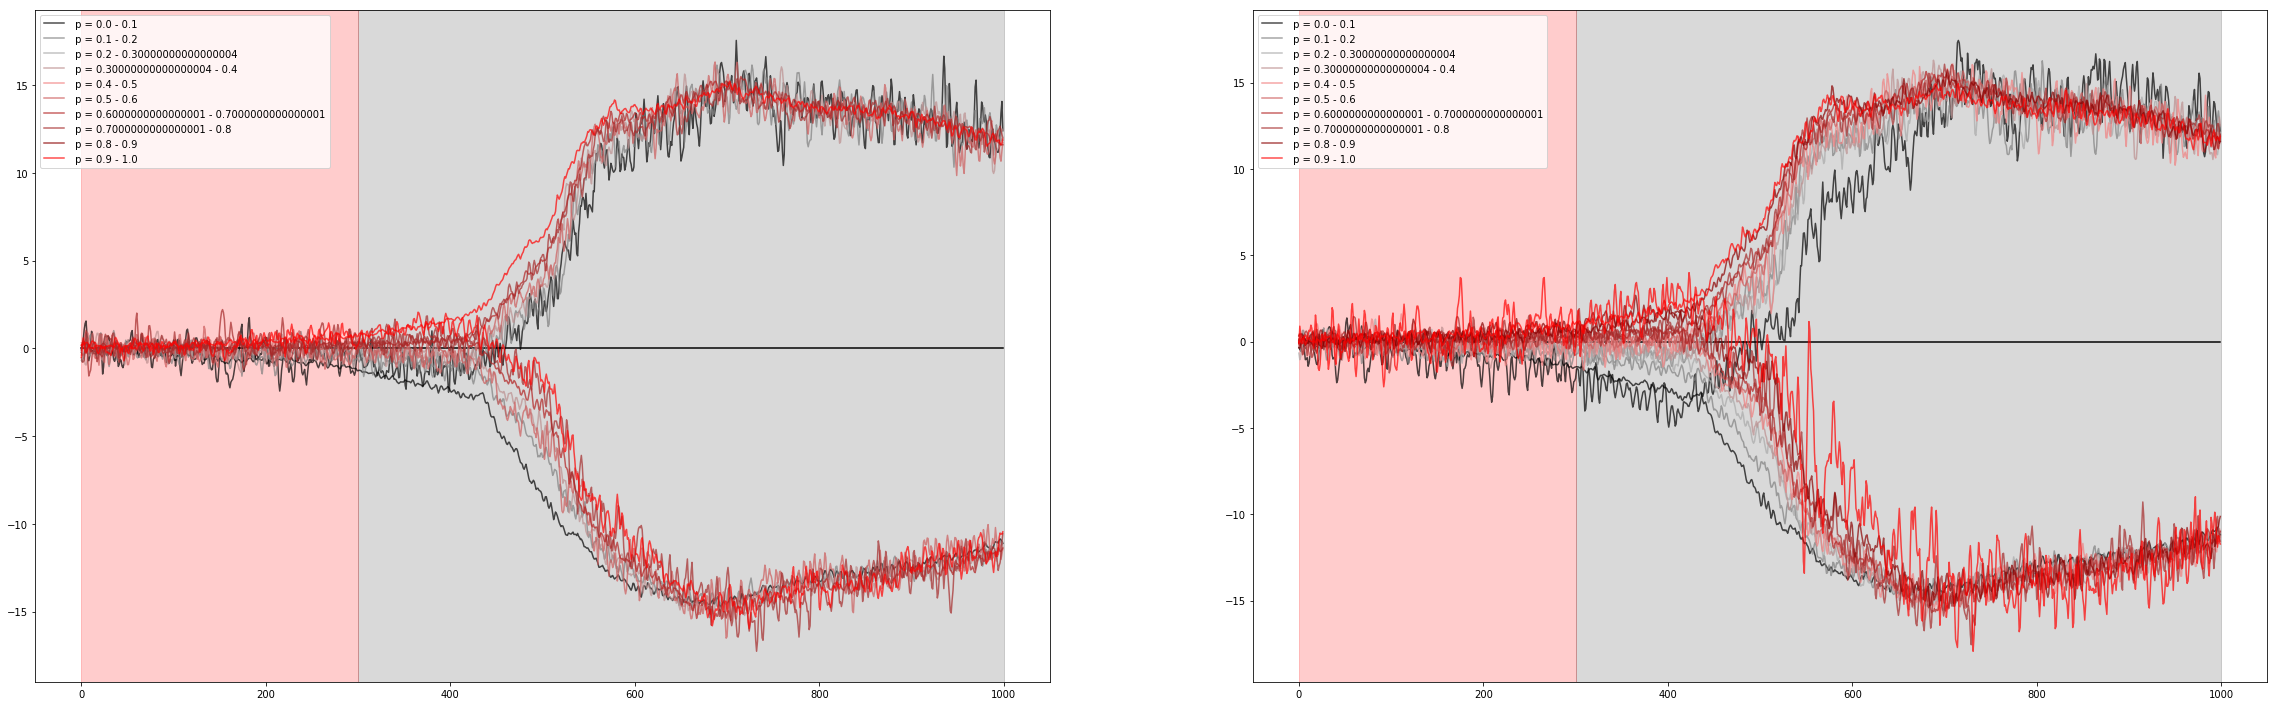

In [10]:
delta = 0.1
color = ['black','grey','darkgrey','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']
PROBA = np.arange(0,1,delta)

fig_width = 20
fig, axs = plt.subplots(1, 2, figsize=(2*fig_width, 1*fig_width/(1.6180*1)))

axs[0] = Trace_Moyenne_P_reel(delta, color, PROBA, ax=axs[0])
axs[1] = Trace_Moyenne_P_hat(delta, color, PROBA, ax=axs[1])
plt.show()

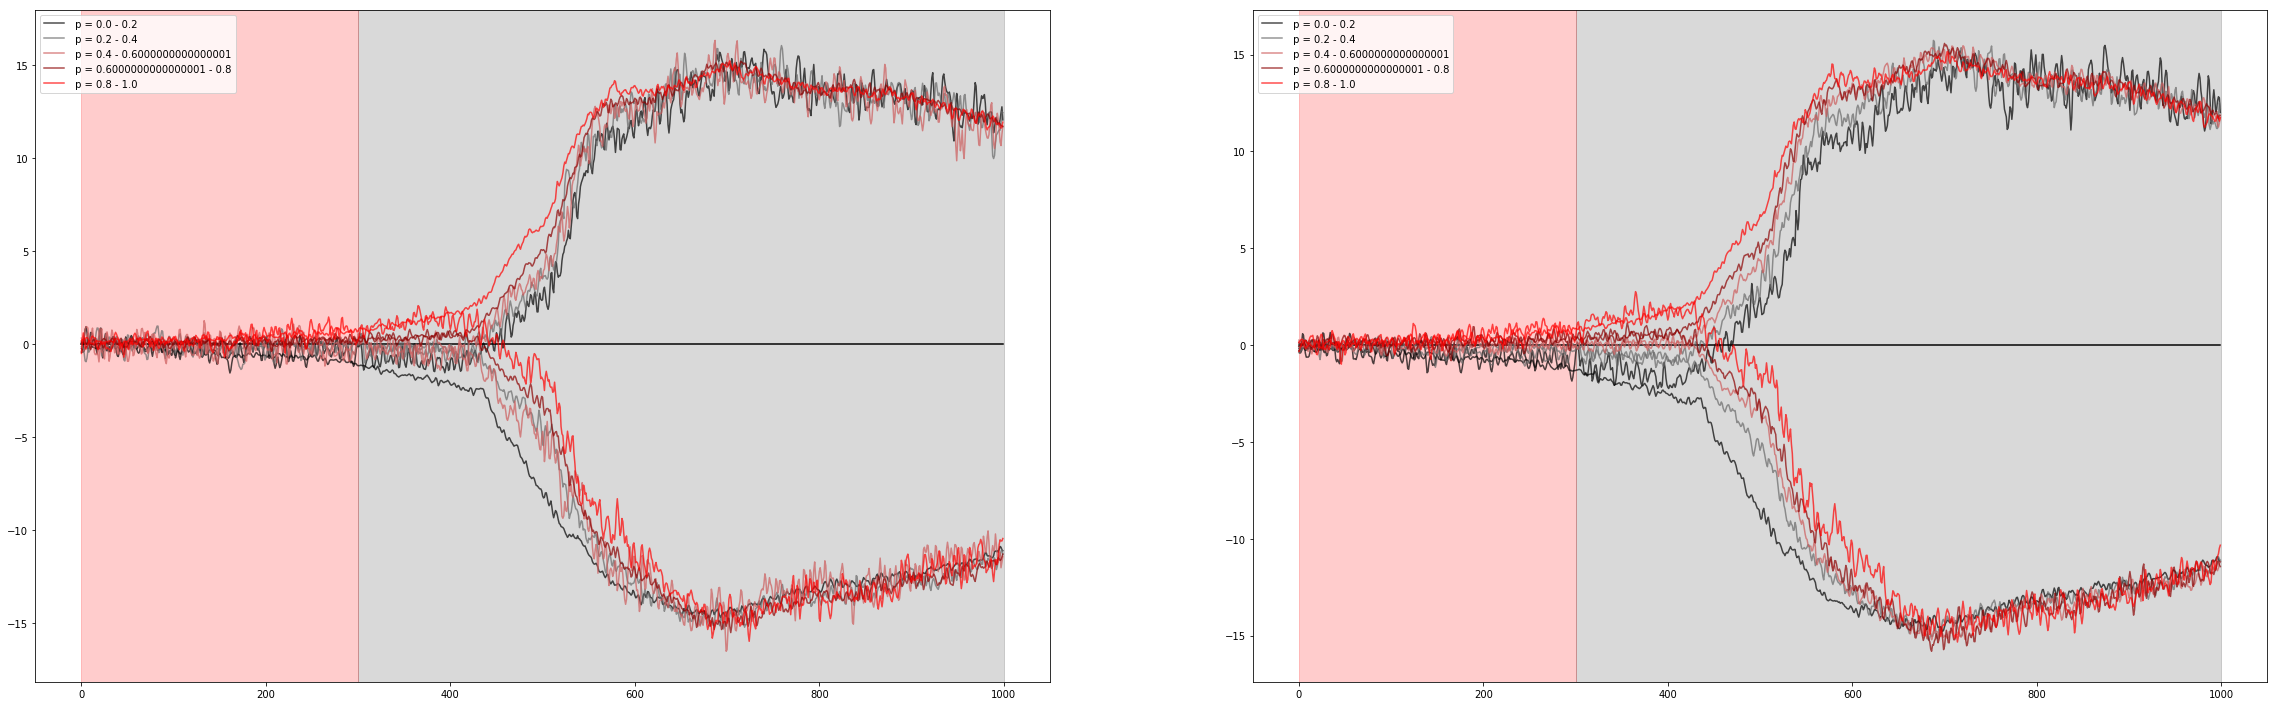

In [11]:
delta = 0.2
color = ['black','dimgrey','indianred','darkred','red']
PROBA = np.arange(0,1,delta)

fig_width = 20
fig, axs = plt.subplots(1, 2, figsize=(2*fig_width, 1*fig_width/(1.6180*1)))

axs[0] = Trace_Moyenne_P_reel(delta, color, PROBA, ax=axs[0])
axs[1] = Trace_Moyenne_P_hat(delta, color, PROBA, ax=axs[1])
plt.show()

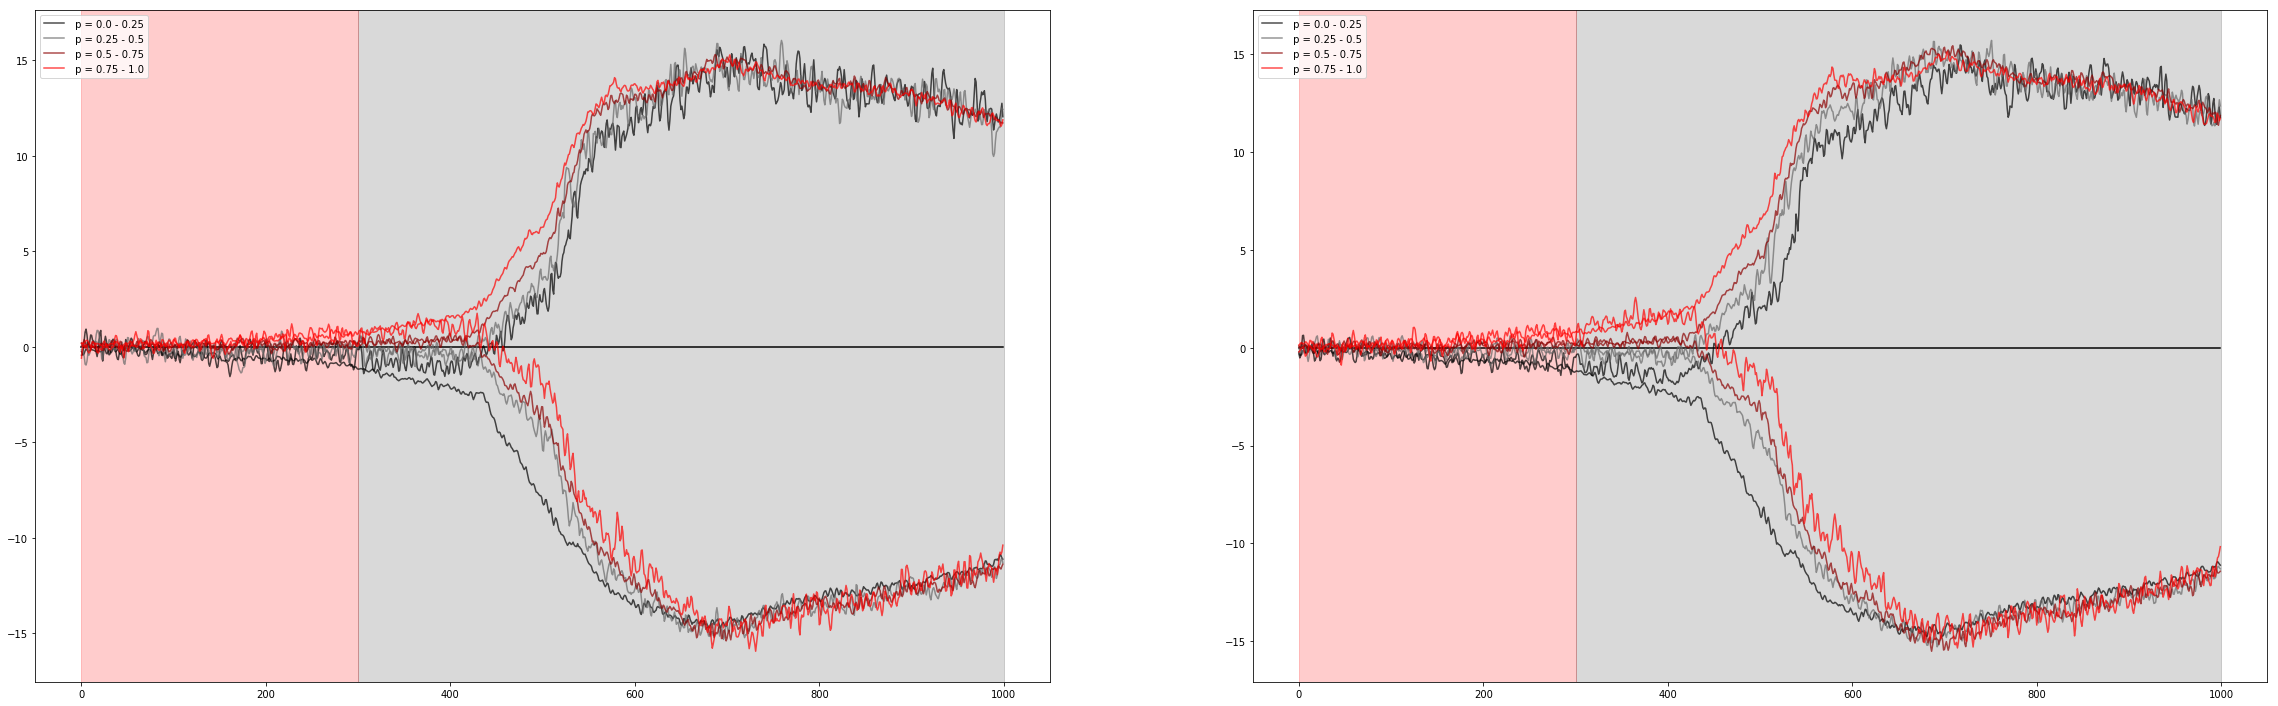

In [12]:
delta = 0.25
color = ['black','dimgrey','darkred','red']
PROBA = np.arange(0,1,delta)

fig_width = 20
fig, axs = plt.subplots(1, 2, figsize=(2*fig_width, 1*fig_width/(1.6180*1)))

axs[0] = Trace_Moyenne_P_reel(delta, color, PROBA, ax=axs[0])
axs[1] = Trace_Moyenne_P_hat(delta, color, PROBA, ax=axs[1])
plt.show()